<a href="https://colab.research.google.com/github/annasajkh/Face-Generator/blob/main/Conv_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

!kaggle datasets download -d greatgamedota/ffhq-face-data-set

In [ ]:
!unzip ffhq-face-data-set.zip

In [5]:
import glob
from PIL import Image
import numpy as np

imgs = []

count = 0

for file in glob.glob("thumbnails128x128/*"):
  imgs.append(np.array(Image.open(file).resize((64,64))) / 255)
  count += 1

  if count == 20_000:
    break

np.save("face_dataset.npy", np.array(imgs))

In [6]:
%cp drive/MyDrive/face_dataset.npy /content/

In [7]:
%cp drive/MyDrive/face_model.pkl /content/

In [8]:
from tqdm import tqdm
from torch.nn.modules.linear import Linear
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import numpy as np

dataset = torch.from_numpy(np.load("face_dataset.npy")).float()
print(len(dataset))
if torch.cuda.is_available():
  dataset = dataset.cuda()

dataset = dataset.view(len(dataset), 3, 64, 64)

batch_size = 32

20000


In [9]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
      nn.Conv2d(3, 120, kernel_size=3, stride=2, padding=1),
      nn.LeakyReLU(True),

      nn.Conv2d(120, 160, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(160),
      nn.LeakyReLU(True),

      nn.Conv2d(160, 200, kernel_size=3, stride=2, padding=0),
      nn.LeakyReLU(True),

      nn.Flatten()
    )

    self.fc1 = nn.Sequential(
      nn.Linear(9800, 600),
      nn.LeakyReLU(True)
    )

    self.fc2 = nn.Sequential(
      nn.Linear(300, 600),
      nn.LeakyReLU(True),

      nn.Linear(600, 9800),
      nn.LeakyReLU(True)
    )


    self.decoder = nn.Sequential(      
      nn.ConvTranspose2d(200, 160, kernel_size=3, stride=2, output_padding=0),
      nn.BatchNorm2d(160),
      nn.ReLU(True),

      nn.ConvTranspose2d(160, 120, kernel_size=5, stride=2, padding=1, output_padding=1),
      nn.BatchNorm2d(120),
      nn.ReLU(True),

      nn.ConvTranspose2d(120, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )
  
  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the encoder's latent space
    :param log_var: log variance from the encoder's latent space
    """
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling as if coming from the input space
    return sample

  def forward(self, x):
    #code from https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

    x = self.encode(x).view(-1, 2, 300)

    # get `mu` and `log_var`
    mu = x[:, 0, :] # the first feature values as mean
    log_var = x[:, 1, :] # the other feature values as variance
    # get the latent vector through reparameterization
    z = self.reparameterize(mu, log_var)

    x = self.decode(z)
    return x, mu, log_var
  
  def encode(self, x):
    x = self.encoder(x)
    x = self.fc1(x)
    return x

  def decode(self, x):
    x = self.fc2(x)
    x = x.view(x.shape[0], 200, 7, 7)
    x = self.decoder(x)
    return x

#code from https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [10]:
model = AutoEncoder()
model.load_state_dict(torch.load("face_model.pkl", map_location=torch.device("cpu")))
optimizer = Adam(model.parameters(), lr=3e-4)
loss_function = nn.BCELoss(reduction="sum")

if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()

In [ ]:
model = AutoEncoder()
optimizer = Adam(model.parameters(), lr=3e-4)
loss_function = nn.BCELoss(reduction="sum")

if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()

In [ ]:
model.train()

epoch = 10_000

for e in tqdm(range(epoch)):
  running_loss = 0.0
  for i in range(1, int(len(dataset) / batch_size)):
    data = dataset[(i-1)*batch_size:i*batch_size]
    optimizer.zero_grad()
    reconstruction, mu, logvar = model(data)
    bce_loss = loss_function(reconstruction, data)
    loss = final_loss(bce_loss, mu, logvar)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()
  
  train_loss = running_loss/len(dataset)

  print(f"Epoch: {e}\nLoss: {train_loss}")

  torch.save(model.state_dict(), "drive/MyDrive/face_model.pkl")

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0
Loss: 7350.1315140625


  0%|          | 1/10000 [00:37<103:48:07, 37.37s/it]

Epoch: 1
Loss: 7052.1926859375


  0%|          | 2/10000 [01:14<103:20:41, 37.21s/it]

Epoch: 2
Loss: 6989.5283015625


  0%|          | 3/10000 [01:51<103:05:34, 37.12s/it]

Epoch: 3
Loss: 6957.41110703125


  0%|          | 4/10000 [02:28<102:55:24, 37.07s/it]

Epoch: 4
Loss: 6937.2370859375


  0%|          | 5/10000 [03:05<102:48:35, 37.03s/it]

Epoch: 5
Loss: 6923.551128125


  0%|          | 6/10000 [03:42<102:45:55, 37.02s/it]

Epoch: 6
Loss: 6914.7116421875


  0%|          | 7/10000 [04:19<102:43:21, 37.01s/it]

Epoch: 7
Loss: 6907.695646875


  0%|          | 8/10000 [04:56<102:40:28, 36.99s/it]

In [11]:
print(len(dataset))

20000


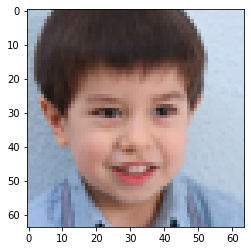

In [14]:
import matplotlib.pyplot as plt

model.eval()
plt.imshow(dataset[0].cpu().reshape(64, 64, 3))

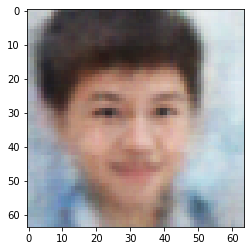

In [15]:
reconstruction, mu, logvar = model(dataset[0].view(1, 3, 64, 64))
plt.imshow(reconstruction.cpu().detach().reshape(64, 64, 3))